# Maji Ndogo — Temperature vs Yield (Simple Linear Regression)
**Exploratory analysis and baseline linear regression to investigate how average temperature relates to standard yield.**

*This notebook was originally produced as part of an ALX regression exercise; the content has been adapted and cleaned for portfolio presentation.*


## Model Evaluation

Simple linear regression is a fundamental statistical method used to quantify the relationship between two variables. It allows us to predict an outcome (dependent variable) based on the value of one predictor (independent variable). In this challenge, This notebook will apply simple linear regression to understand how different environmental factors affect the standardised yield of crops.

Our insights will not only help local farmers maximise their harvests but also contribute to the sustainable agriculture practices in Maji Ndogo.

## Initial Data Exploration
This section explores the structure and basic properties of the dataset before modeling.


## Data Loading

Before building our regression model, we first need to understand the dataset.  
The data was collected through agricultural surveys conducted at farms across Maji Ndogo and includes various factors that may influence crop yield — such as field elevation and average temperature.

The next section reviews the data dictionary and encourages initial observations about what factors could affect yield.


### Data Dictionary

Below is a brief description of each feature included in the Maji Ndogo dataset.

#### 1. Geographic Features
- **Field_ID:** Unique identifier for each field (BigInt).  
- **Elevation:** Elevation of the field above sea level (metres, Float).  
- **Latitude:** Geographical latitude of the field (degrees, Float). *(Dummy variable – may contain simulated relationships)*  
- **Longitude:** Geographical longitude of the field (degrees, Float). *(Dummy variable – may contain simulated relationships)*  
- **Location:** Province or region where the field is located (Text).  
- **Slope:** The slope or gradient of the land (Float).  

#### 2. Weather Features
- **Rainfall:** Amount of rainfall in the area (mm, Float).  
- **Min_temperature_C:** Average minimum temperature recorded (°C, Float). *(Dummy variable)*  
- **Max_temperature_C:** Average maximum temperature recorded (°C, Float). *(Dummy variable)*  
- **Ave_temps:** Average temperature recorded (°C, Float).  

#### 3. Soil and Crop Features
- **Soil_fertility:** Measure of soil fertility where 0 = infertile and 1 = highly fertile (Float).  
- **Soil_type:** Type of soil in the field (Text).  
- **pH:** pH level of the soil, indicating acidity or alkalinity (Float).  

#### 4. Farm Management Features
- **Pollution_level:** Level of environmental pollution (0 = unpolluted, 1 = highly polluted) (Float).  
- **Plot_size:** Size of the plot (hectares, Float). *(Dummy variable)*  
- **Chosen_crop:** Type of crop cultivated (Text).  
- **Annual_yield:** Total output of the field (Float). *(Removed – redundant with `Standard_yield`)*  

#### 5. Target Variable
- **Standard_yield:** Standardised yield per field, normalised per crop (Float).  
  - Independent of field size or crop type.  
  - Used as the target variable for regression analysis.


## Data Loading & Setup

In this section, the dataset is imported using custom helper modules (`data_ingestion.py` and `field_data_processor.py`).  
These modules handle reading, cleaning, and structuring the Maji Ndogo agricultural data for analysis.

> **Note:** The helper scripts were adapted from the ALX learning materials and are available in the [Explore-AI public repository](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip).


In [1]:
# Read database and prepare dataset using helper modules
import re
import numpy as np
import pandas as pd
import logging
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
        SELECT *
        FROM geographic_features
        LEFT JOIN weather_features USING (Field_ID)
        LEFT JOIN soil_and_crop_features USING (Field_ID)
        LEFT JOIN farm_management_features USING (Field_ID)
        """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    # NOTE: verify this mapping is intentional — it currently swaps Annual_yield and Crop_type
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
        'Rainfall': r'(\d+(\.\d+)?)\s?mm',
        'Temperature': r'(\d+(\.\d+)?)\s?C',
        'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
    },
}

try:
    field_processor = FieldDataProcessor(config_params)
    field_processor.process()
    field_df = field_processor.df.copy()
    logging.info("Field data loaded and processed. Shape: %s", field_df.shape)
except Exception as e:
    logging.exception("Error processing field data: %s", e)
    raise

# We are not using the weather processor in this analysis.
# If you want to include weather data later, uncomment and use the WeatherDataProcessor.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

# Safely drop the Weather_station column if present
dataset = field_df.drop(columns=["Weather_station"], errors='ignore')


2025-11-05 15:51:40,788 - data_ingestion - INFO - Database engine created successfully.
2025-11-05 15:51:40,873 - data_ingestion - INFO - Query executed successfully.
2025-11-05 15:51:40,874 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2025-11-05 15:51:40,876 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2025-11-05 15:51:41,642 - data_ingestion - INFO - CSV file read successfully from the web.
2025-11-05 15:51:41,647 - root - INFO - Field data loaded and processed. Shape: (5654, 19)


### Quick look at the dataset

Below is a brief preview and summary of the cleaned dataset to confirm the structure, number of rows/columns, and a few sample records before we proceed with EDA.


In [2]:
# Quick dataset checks
print("Shape:", dataset.shape)
display(dataset.head(8))    # show a small sample
print("\nColumns and dtypes:")
display(dataset.dtypes)
print("\nMissing values per column:")
display(dataset.isnull().sum())


Shape: (5654, 18)


,Field_ID,Elevation,Latitude,Longitude,Location,Slope,Rainfall,Min_temperature_C,Max_temperature_C,Ave_temps,Soil_fertility,Soil_type,pH,Pollution_level,Plot_size,Annual_yield,Crop_type,Standard_yield
0,40734,786.05580,-7.389911,-7.556202,Rural_Akatsi,14.795113,1125.2,-3.1,33.1,15.00,0.62,Sandy,6.169393,8.526684e-02,1.3,0.751354,cassava,0.577964
1,30629,674.33410,-7.736849,-1.051539,Rural_Sokoto,11.374611,1450.7,-3.9,30.6,13.35,0.64,Volcanic,5.676648,3.996838e-01,2.2,1.069865,cassava,0.486302
2,39924,826.53390,-9.926616,0.115156,Rural_Sokoto,11.339692,2208.9,-1.8,28.4,13.30,0.69,Volcanic,5.331993,3.580286e-01,3.4,2.208801,tea,0.649647
3,5754,574.94617,-2.420131,-6.592215,Rural_Kilimani,7.109855,328.8,-5.8,32.2,13.20,0.54,Loamy,5.328150,2.866871e-01,2.4,1.277635,cassava,0.532348
4,14146,886.35300,-3.055434,-7.952609,Rural_Kilimani,55.007656,785.2,-2.5,31.0,14.25,0.72,Sandy,5.721234,4.319027e-02,1.5,0.832614,wheat,0.555076
5,5304,850.56647,-2.050665,-7.132769,Rural_Kilimani,50.451250,649.4,-3.0,29.5,13.25,0.70,Sandy,5.484350,1.275280e-01,1.7,1.112611,potato,0.654477
6,429,331.35538,-13.409517,-6.722849,Rural_Hawassa,5.907423,1586.0,-6.8,31.8,12.50,0.63,Silt,7.061317,4.315457e-07,2.9,0.994325,banana,0.342871
7,672,790.73846,-3.785356,-1.470468,Rural_Kilimani,15.380596,1188.3,-3.0,31.0,14.00,0.63,Sandy,4.577043,6.131074e-01,1.4,0.558899,tea,0.399214



Columns and dtypes:


Field_ID               int64
Elevation            float64
Latitude             float64
Longitude            float64
Location              object
Slope                float64
Rainfall             float64
Min_temperature_C    float64
Max_temperature_C    float64
Ave_temps            float64
Soil_fertility       float64
Soil_type             object
pH                   float64
Pollution_level      float64
Plot_size            float64
Annual_yield         float64
Crop_type             object
Standard_yield       float64
dtype: object


Missing values per column:


Field_ID             0
Elevation            0
Latitude             0
Longitude            0
Location             0
Slope                0
Rainfall             0
Min_temperature_C    0
Max_temperature_C    0
Ave_temps            0
Soil_fertility       0
Soil_type            0
pH                   0
Pollution_level      0
Plot_size            0
Annual_yield         0
Crop_type            0
Standard_yield       0
dtype: int64

In [3]:
# Validate the data
# !pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts =============================
platform win32 -- Python 3.12.9, pytest-8.4.2, pluggy-1.6.0 -- C:\Users\dell\anaconda3\envs\sql_package\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\dell\Desktop\2025\ALX\Machine Learning\Maji_Ndogo_Project\notebook
plugins: anyio-4.7.0
collecting ... collected 4 items

validate_data.py::test_read_field_dataframe_shape PASSED                 [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                    [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED     [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                       [100%]

============================== 4 passed in 0.75s ==============================
Deleted sampled_field_df.csv


============================= test session starts ==============================
platform linux -- Python 3.11.8, pytest-8.2.2, pluggy-1.6.0 -- /usr/local/bin/python
cachedir: .pytest_cache
metadata: {'Python': '3.11.8', 'Platform': 'Linux-4.4.0-x86_64-with-glibc2.36', 'Packages': {'pytest': '8.2.2', 'pluggy': '1.6.0'}, 'Plugins': {'asyncio': '0.23.8', 'json-report': '1.5.0', 'metadata': '3.1.1', 'cov': '5.0.0', 'ddtrace': '2.8.7', 'Faker': '8.13.2', 'anyio': '4.10.0'}}
rootdir: /mnt/data
plugins: asyncio-0.23.8, json-report-1.5.0, metadata-3.1.1, cov-5.0.0, ddtrace-2.8.7, Faker-8.13.2, anyio-4.10.0
asyncio: mode=Mode.STRICT
collected 0 items                                                              

============================ no tests ran in 0.01s =============================
ERROR: file or directory not found: validate_data.py



Deleted sampled_field_df.csv


## Challenge 1 — Visualising the Relationship

With the dataset prepared, the first step was to explore potential linear relationships between the available features and the target variable, `Standard_yield`. Identifying such relationships provides insight into which variables may serve as strong predictors in later modeling stages.

The initial analysis focused on `Ave_temps`, representing the average temperature of each field, to examine whether temperature influences crop yield. A scatter plot was generated to visualize this relationship and assess whether a linear pattern is evident.


In [4]:
# Create visualizations
import matplotlib.pyplot as plt

### Scatter Plot — Average Temperature vs Standardized Yield

The scatter plot below visualizes the relationship between **average temperature (`Ave_temps`)** and **standardized yield (`Standard_yield`)**.  
A trend line is included to assess whether a **linear relationship** may exist between the two variables — a key assumption for applying linear regression.


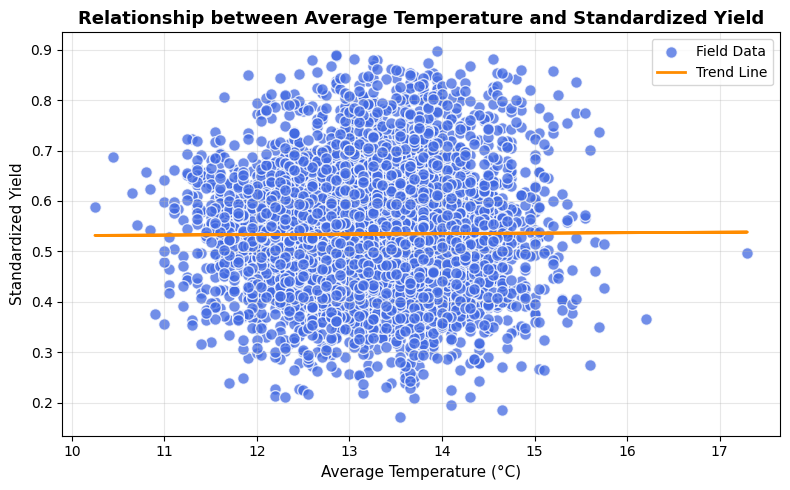

In [5]:
plt.figure(figsize=(8, 5))  # Adjust figure size for better readability

# Create scatter plot with improved aesthetics
plt.scatter(
    dataset['Ave_temps'],
    dataset['Standard_yield'],
    color='royalblue',
    edgecolor='white',
    alpha=0.75,
    s=70,  # marker size
    label='Field Data'
)

# Add trend line for better visual interpretation
z = np.polyfit(dataset['Ave_temps'], dataset['Standard_yield'], 1)
p = np.poly1d(z)
plt.plot(dataset['Ave_temps'], p(dataset['Ave_temps']), color='darkorange', linewidth=2, label='Trend Line')

# Add titles and labels
plt.title('Relationship between Average Temperature and Standardized Yield', fontsize=13, fontweight='bold')
plt.xlabel('Average Temperature (°C)', fontsize=11)
plt.ylabel('Standardized Yield', fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

## Correlation Analysis — Quantifying the Relationship

To complement the visual analysis, we compute the **Pearson correlation coefficient** between average temperature (`Ave_temps`) and standardized yield (`Standard_yield`).  
This metric measures the **strength and direction** of the linear relationship between the two variables.

A value close to **+1** indicates a strong positive linear relationship, while values near **0** suggest little or no linear correlation.


### Setup for Correlation Computation

We'll import the required statistical function from the `scipy.stats` module to calculate the Pearson correlation coefficient between temperature and yield.


In [6]:
from scipy.stats import pearsonr

### Function Definition — Pearson Correlation

The function below calculates the **Pearson correlation coefficient** between two numerical columns in a DataFrame.  
It returns a floating-point value representing the **strength and direction** of the linear association between the variables.


In [7]:
def get_correlation(df, col1, col2):
    """
    Calculates the Pearson correlation coefficient between two numerical columns.

    Parameters:
        df (pd.DataFrame): The dataset containing the columns of interest.
        col1 (str): The name of the first column.
        col2 (str): The name of the second column.

    Returns:
        float: The Pearson correlation coefficient representing the linear relationship between the two variables.
    """
    correlation, _ = pearsonr(df[col1], df[col2])
    return float(correlation)

In [8]:
correlation = get_correlation(dataset, 'Ave_temps', 'Standard_yield')
print(f"Pearson correlation coefficient: {correlation:.4f}")

Pearson correlation coefficient: 0.0068


### **Interpretation**

The Pearson correlation coefficient between `Ave_temps` and `Standard_yield` is **0.0068**, which is effectively zero.  
This indicates **no linear relationship** between average temperature and standardized yield in the available data.  

**Possible reasons:**  
- The relationship may be **non-linear** (not captured by Pearson's r).  
- Other features (e.g., **soil fertility**, **rainfall**, **management practices**) may be stronger predictors.  
- **Data issues** such as outliers, measurement inconsistencies, or low variance could be masking relationships.

---

### **Scatter Plot Analysis**

The scatter plot reveals a **weak or negligible linear relationship** between average temperature and standardized yield.  
The wide dispersion of data points suggests that **temperature alone is not a strong predictor** of crop yield in this dataset.  

This visual observation is **consistent with the low Pearson correlation coefficient**, implying that other factors—such as **soil characteristics, rainfall, or management practices**—likely exert a greater influence on yield outcomes.


## Challenge 2 — Pollution as a Predictor

After examining temperature, the analysis shifts focus to **pollution levels** as a potential driver of crop yield variation. Pollution can affect plant health, soil quality, and photosynthetic efficiency — all of which may influence agricultural productivity.

To investigate this relationship, a **simple linear regression model** is fitted using `Pollution_level` as the independent variable and `Standard_yield` as the dependent variable.  
This model aims to quantify whether pollution levels have a measurable linear impact on standardized yield across the surveyed farms.


In [9]:
# Train model / split data
from sklearn.linear_model import LinearRegression

In [10]:
def fit_linear_regression_model(df, pollution_col, yield_col):
    """
    Fits a simple linear regression model to evaluate the relationship 
    between pollution levels and standardized crop yield.

    Parameters:
        df (pd.DataFrame): The dataset containing the relevant columns.
        pollution_col (str): Name of the column representing pollution levels (independent variable).
        yield_col (str): Name of the column representing standardized yield (dependent variable).

    Returns:
        tuple:
            model (LinearRegression): The trained regression model.
            predictions (np.ndarray): Predicted values generated by the model.
            y (np.ndarray): Actual observed yield values.
    """
    # Prepare input features and target variable
    X = df[[pollution_col]].to_numpy()
    y = df[yield_col].to_numpy()

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Generate predictions
    predictions = model.predict(X)

    return model, predictions, y

In [11]:
# Code cell — step in the analysis pipeline
model, predictions, y_values = fit_linear_regression_model(dataset, 'Pollution_level', 'Standard_yield')
print(f"Model: {model}")
print(f"Predictions: {predictions}")
print(f"Actual Y-Values: {y_values}")

Model: LinearRegression()
Predictions: [0.5540956  0.50920888 0.51515565 ... 0.56626844 0.56626844 0.52896886]
Actual Y-Values: [0.57796436 0.48630219 0.64964738 ... 0.80077564 0.5075954  0.4530639 ]


### Visualizing Pollution and Crop Yield Relationship

To assess the suitability of a linear model, it is essential to first visualize the relationship between **pollution levels** and standardized yield.  
The scatter plot below illustrates the distribution of data points, while the regression line—derived from the model’s predictions—highlights the general direction and strength of the relationship.  

This visualization provides a clear indication of how closely the observed data align with a linear trend, offering insight into the model’s ability to capture the underlying pattern between pollution and agricultural output.


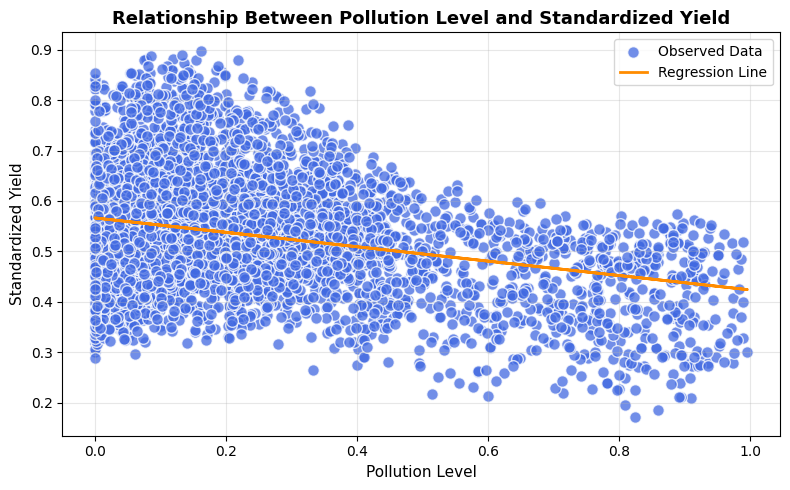

In [12]:
X = dataset[['Pollution_level']]
y = dataset['Standard_yield']
# Visualizing the relationship between pollution levels and standardized yield

plt.figure(figsize=(8, 5))

# Scatter plot of actual data points
plt.scatter(
    X,
    y,
    color='royalblue',
    edgecolor='white',
    alpha=0.75,
    s=70,
    label='Observed Data'
)

# Regression line based on model predictions
plt.plot(
    X,
    predictions,
    color='darkorange',
    linewidth=2,
    label='Regression Line'
)

# Axis labels and title
plt.xlabel('Pollution Level', fontsize=11)
plt.ylabel('Standardized Yield', fontsize=11)
plt.title('Relationship Between Pollution Level and Standardized Yield', fontsize=13, fontweight='bold')

# Aesthetic refinements
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
# Code cell — step in the analysis pipeline
Pollution_correlation = get_correlation(dataset,'Pollution_level','Standard_yield')
print("Pearson correlation coefficient:", Pollution_correlation)

Pearson correlation coefficient: -0.2857609646210545


### Interpretation of Results

The relationship between **pollution levels** and standardized yield appears noticeably more linear than the one observed with average temperature.  
In this case, the data points align more closely around the regression line, suggesting a stronger and more consistent association.  

This indicates that pollution may serve as a better single-variable predictor of crop yield compared to temperature, although further analysis with additional features would be required to confirm the robustness of this relationship.


### Interpreting Model Coefficients

A deeper understanding of the linear regression model can be obtained by examining its **slope** and **intercept**.  
The slope represents the expected change in standardized yield for every unit increase in pollution level, while the intercept indicates the model’s estimated yield when pollution is zero.  

The function below extracts these parameters from the fitted model, providing a concise summary of the regression line’s characteristics.


In [14]:
def get_slope_intercept(model):
    """
    Retrieves the slope and intercept from a fitted linear regression model.

    Parameters:
        model (LinearRegression): A trained linear regression model.

    Returns:
        tuple:
            slope (float): The coefficient representing the rate of change in the dependent variable.
            intercept (float): The predicted value of the dependent variable when the independent variable is zero.
    """
    slope = float(model.coef_[0])
    intercept = float(model.intercept_)
    return slope, intercept


In [15]:
# Code cell — step in the analysis pipeline
slope, intercept = get_slope_intercept(model)
print("Slope:", slope)
print("Intercept:", intercept)

Slope: -0.1427617720986607
Intercept: 0.566268441539338


### Interpretation of Coefficient Values

The **slope** of approximately –0.143 indicates a negative relationship between pollution and standardized yield.  
This suggests that as pollution levels increase, crop yield tends to decrease slightly, though the relatively small magnitude of the coefficient implies that the effect is modest rather than dominant.  

The **intercept** of 0.566 represents the model’s estimated yield when pollution is zero.  
In practical terms, this value serves as the baseline yield in the absence of pollution, helping to contextualize the model’s predictions across varying pollution levels.


## Challenge 3 — Evaluating Pollution’s Predictive Power

Having explored the potential of `Pollution_level` as a predictor, the next step is to assess how well a **simple linear regression model** captures its relationship with `Standard_yield`.  
Visual analysis suggested a possible linear trend, but quantitative evaluation is essential to validate that impression.

To measure the model’s effectiveness, several key performance metrics are calculated:
- **R-squared (R²):** Indicates how much of the variance in yield is explained by pollution levels.  
- **Mean Absolute Error (MAE):** Average deviation of predictions from actual yields.  
- **Mean Squared Error (MSE):** Penalizes larger errors to highlight outliers.  
- **Root Mean Squared Error (RMSE):** Expresses model error in the same units as the target variable.

Together, these metrics help determine whether pollution serves as a meaningful linear predictor of agricultural yield, or whether other variables play a stronger role.


In [16]:
# Train model / split data
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [17]:
def calculate_evaluation_metrics(predictions, y_values):
    """
    Computes key evaluation metrics to assess the performance of a regression model.

    Parameters:
        predictions (array-like): Model-predicted values.
        y_values (array-like): Actual observed values.

    Returns:
        tuple:
            r2 (float): Coefficient of determination, indicating the proportion of variance explained by the model.
            mae (float): Mean Absolute Error, representing the average magnitude of prediction errors.
            mse (float): Mean Squared Error, emphasizing larger deviations.
            rmse (float): Root Mean Squared Error, providing error magnitude in the same units as the target variable.
    """
    r2 = r2_score(y_values, predictions)
    mae = mean_absolute_error(y_values, predictions)
    mse = mean_squared_error(y_values, predictions)
    rmse = np.sqrt(mse)

    return r2, mae, mse, rmse

In [18]:
# Code cell — step in the analysis pipeline
evaluation_metrics = calculate_evaluation_metrics(predictions, y_values)
print(f"Evaluation Metrics:\nR-squared: {evaluation_metrics[0]}\nMAE: {evaluation_metrics[1]}\nMSE: {evaluation_metrics[2]}\nRMSE: {evaluation_metrics[3]}")

Evaluation Metrics:
R-squared: 0.08165932890115568
MAE: 0.08554642090904993
MSE: 0.011477732254034844
RMSE: 0.10713417873878926


### Model Performance Interpretation

The evaluation metrics indicate that the model explains only a small portion of the variance in standardized yield (**R² ≈ 0.082**), suggesting a relatively weak linear relationship between pollution levels and crop yield.  
Although the error values (**MAE ≈ 0.086** and **RMSE ≈ 0.107**) are modest in absolute terms, they highlight that the model’s predictions deviate noticeably from actual observations.  

Overall, while the model captures a slight trend, its low explanatory power implies that pollution alone is not a strong predictor of yield outcomes.


## Challenge 4 — Train–Test Split in Action

To ensure the regression model captures genuine patterns rather than memorizing the data, it’s essential to evaluate its ability to generalize to unseen samples.  
This is achieved through a **train–test split**, a standard validation technique in machine learning.

The dataset is divided into:
- **Training set (80%)** – used to fit the model and learn relationships.  
- **Testing set (20%)** – reserved for evaluating model performance on unseen data.

By doing this, we can assess how well the model performs outside its training environment — a key indicator of reliability and real-world applicability.  
A consistent random seed (`random_state = 42`) is used to ensure the results are reproducible.


In [19]:
# Train model / split data
from sklearn.model_selection import train_test_split

In [20]:
def data_train_test_split(df, pollution_col, yield_col):
    """
    Splits the dataset into training and testing subsets for model evaluation.

    Parameters:
        df (pd.DataFrame): The dataset containing the features and target variable.
        pollution_col (str): The column name representing pollution levels (independent variable).
        yield_col (str): The column name representing standardized yield (dependent variable).

    Returns:
        tuple:
            X_train (pd.DataFrame): Feature data used for training the model.
            X_test (pd.DataFrame): Feature data reserved for testing.
            y_train (pd.Series): Target values corresponding to the training set.
            y_test (pd.Series): Target values corresponding to the test set.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        df[[pollution_col]], 
        df[yield_col],
        test_size=0.2,
        random_state=42
    )
    return X_train, X_test, y_train, y_test

In [21]:
# Train model / split data
X_train, X_test, y_train, y_test = data_train_test_split(dataset, 'Pollution_level', 'Standard_yield')
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (4523, 1), X_test shape: (1131, 1)
y_train shape: (4523,), y_test shape: (1131,)


### Training and Testing the Linear Regression Model

With the data properly partitioned into training and testing subsets, the next step involves **fitting a linear regression model** to the training data.  
This process enables the model to learn the relationship between **pollution level** (the independent variable) and **standardized yield** (the dependent variable).  

Once trained, the model is evaluated on the testing data to assess its **predictive capability on unseen samples**.  
The function below encapsulates this workflow — fitting the model, generating predictions on the test set, and returning both the trained model and evaluation data for further analysis.


In [22]:
# Train model / split data
from sklearn.linear_model import LinearRegression

In [23]:
def train_split_linear_regression_model(X_train, X_test, y_train, y_test):
    """
    Trains a simple linear regression model using the training data 
    and evaluates its performance on the test set.

    Parameters:
        X_train (pd.DataFrame): Feature data used for training the model.
        X_test (pd.DataFrame): Feature data reserved for testing.
        y_train (pd.Series): Target values corresponding to the training set.
        y_test (pd.Series): Target values corresponding to the test set.

    Returns:
        tuple:
            model (LinearRegression): The trained linear regression model.
            y_test_pred (np.ndarray): Predicted values for the test set.
            y_test (pd.Series): Actual observed values for the test set.
    """
    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Generate predictions on the test data
    y_test_pred = model.predict(X_test)

    return model, y_test_pred, y_test

In [24]:
# Code cell — step in the analysis pipeline
train_test_model, predictions_test, y_test = train_split_linear_regression_model(X_train, X_test, y_train, y_test)
print(f"Train-Test Model: {train_test_model}")
print(f"Test Predictions: {predictions_test}")
print(f"Test Actual Y-Values: {y_test}")

Train-Test Model: LinearRegression()
Test Predictions: [0.56412206 0.56167249 0.55638552 ... 0.53129108 0.53868457 0.56431394]
Test Actual Y-Values: 4816    0.446290
5096    0.650771
4706    0.531284
1499    0.516429
3544    0.555724
          ...   
3982    0.540212
4952    0.670387
1071    0.353658
718     0.535224
4103    0.470315
Name: Standard_yield, Length: 1131, dtype: float64


### Evaluating Model Performance on the Test Set

With the model trained on the 80% training subset, its performance is now evaluated on the unseen 20% test data.  
This step assesses how well the model generalizes beyond the training samples.

Using the previously defined `calculate_evaluation_metrics` function, the following metrics are computed:
- **R-squared (R²):** Measures how much of the variance in yield is explained by pollution levels.  
- **Mean Absolute Error (MAE):** Average magnitude of prediction errors.  
- **Mean Squared Error (MSE):** Penalizes larger deviations more strongly.  
- **Root Mean Squared Error (RMSE):** Expresses error magnitude in the same units as yield.

Evaluating these metrics on the test set provides insight into whether the model’s predictive capability holds up when exposed to new data.


In [25]:
# Add code to calculate the R-squared, MAE, MSE, and RMSE
evaluation_metrics = calculate_evaluation_metrics(predictions_test, y_test)
print(f"Evaluation Metrics:\nR-squared: {evaluation_metrics[0]}\nMAE: {evaluation_metrics[1]}\nMSE: {evaluation_metrics[2]}\nRMSE: {evaluation_metrics[3]}")

Evaluation Metrics:
R-squared: 0.08065722992150848
MAE: 0.087949421197475
MSE: 0.012250634233355656
RMSE: 0.11068258324305436


### Model Evaluation & Reflection

The model’s test performance metrics indicate a relatively weak fit:  
- **R² ≈ 0.08** shows that pollution levels explain only a small portion of the variation in standardized yield.  
- The **low MAE and RMSE** values suggest that while prediction errors are modest, the model still struggles to capture meaningful patterns in the data.

Compared to the earlier model trained and evaluated on the same dataset, this version performs slightly worse — and that’s expected.  
When a model is evaluated on unseen data, its apparent accuracy typically declines because it can no longer rely on patterns memorized from training.

**Key insights:**
- The decrease in R² indicates that the earlier model was likely **overfitting** — performing well on known data but poorly on new data.  
- This train–test approach gives a **more realistic estimate of predictive power**, making it the more reliable choice despite the lower scores.  
- The findings reinforce that pollution alone is an **incomplete predictor** of crop yield, suggesting the need for additional variables or a multivariate model in future work.


## Challenge 5: Diagnosing Model Fit through Residual Analysis

Residual analysis helps us determine whether our linear regression model satisfies the core assumptions of:
- **Linearity** – the relationship between features and target should be linear.  
- **Independence** – residuals should not be correlated with each other.  
- **Homoscedasticity** – residuals should have constant variance across predictions.

Even if evaluation metrics look good, violating these assumptions can make the model unreliable and its predictions misleading.

### Residual Calculation
We calculated the residuals as the difference between actual and predicted values from the test set:

\[
\text{Residuals} = y_{test} - \hat{y}_{test}
\]

A histogram of these residuals allows us to assess how well the model captures the underlying data patterns.

### Observations

- The residuals should ideally be **centered around zero** with a roughly **normal distribution**.  
- If the histogram shows **skewness** or **distinct patterns**, it indicates the model fails to capture certain relationships — a sign of **non-linearity** or **heteroscedasticity**.  
- Given earlier weak metrics and visual patterns, it’s likely that our linear model is **not an ideal fit** for predicting `Standard_yield` using only `Pollution_level`.  

**Conclusion:**  
If the residuals are not randomly distributed around zero or exhibit non-constant variance, we **cannot confidently rely on this linear model**. This suggests exploring **non-linear models or adding additional predictors** to improve model performance and interpretability.


In [26]:
# Create visualizations
import matplotlib.pyplot as plt

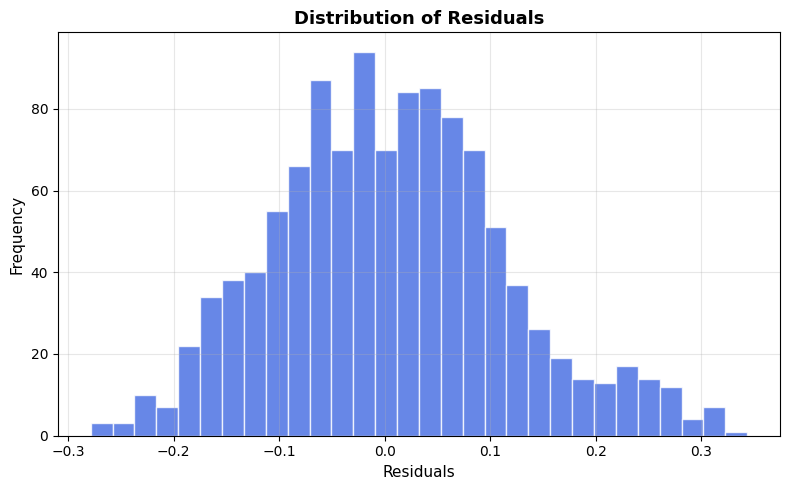

In [27]:
# Code cell — step in the analysis pipeline
# Analyzing the distribution of residuals
residuals = y_test - predictions_test  # Calculate residuals

plt.figure(figsize=(8, 5))
plt.hist(
    residuals,
    bins=30,
    color='royalblue',
    edgecolor='white',
    alpha=0.8
)

plt.title("Distribution of Residuals", fontsize=13, fontweight='bold')
plt.xlabel("Residuals", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Residual Histogram Analysis

Residuals help us evaluate whether our model’s predictions deviate systematically from actual values. A well-fitted linear regression model should produce residuals that are **randomly distributed** around zero and **approximately normal** in shape.

### 1. Distribution Shape – Assessing Normality
 
The residuals exhibit a roughly bell-shaped distribution, with most values concentrated around zero.  
However, the histogram shows a slight right skew, suggesting minor deviations from perfect normality.

### 2. Tail Behavior – Evaluating Skewness and Outliers

The right tail extends marginally farther than the left, indicating mild positive skewness.  
There are no visible outliers or heavy tails, implying that the deviations are not severe and that the residuals are generally well-behaved.  
This pattern suggests that prediction errors are fairly consistent, though the skew may reflect slight underestimation at higher predicted yields.

### 3. Centering Around Zero – Assessing Model Bias
 
The residuals are centered close to zero, indicating that the model’s predictions are largely unbiased.  
There is no evident systematic tendency to overpredict or underpredict across the dataset.

---

### 🔍 Summary
The residual histogram suggests that while our linear regression model performs reasonably well, the **minor right skew** hints at small deviations from normality.  
This may indicate that the linear model captures the general trend but struggles slightly with higher-yield predictions, warranting exploration of **non-linear models or feature expansion** for improved accuracy.


## Residuals vs Predicted Values

A residuals vs predicted values plot allows us to visually assess whether the residuals are randomly distributed.  
If the residuals appear scattered randomly around zero, it suggests that the **linear model is appropriate**.  
However, visible patterns (such as curves or funnels) indicate potential **non-linearity or heteroscedasticity** (unequal variance).

### Task
Create a scatter plot of the residuals against the predicted values (`predictions_test` on the x-axis and `residuals` on the y-axis).

You can add a horizontal reference line at zero to better visualize the centering of residuals:
```python
plt.axhline(y=0, color='r', linestyle='--')


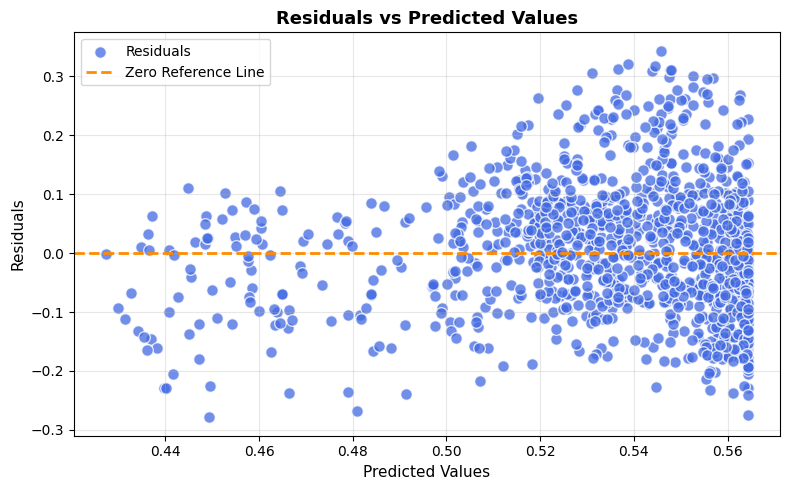

In [28]:
# Visualizing residuals versus predicted values
plt.figure(figsize=(8, 5))

plt.scatter(
    predictions_test,
    residuals,
    color='royalblue',
    edgecolor='white',
    alpha=0.75,
    s=70,
    label='Residuals'
)

# Reference line at zero
plt.axhline(y=0, color='darkorange', linestyle='--', linewidth=2, label='Zero Reference Line')

# Titles and labels
plt.title("Residuals vs Predicted Values", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=11)
plt.ylabel("Residuals", fontsize=11)

# Aesthetic refinements
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Residuals vs Predicted Values — Model Fit Reflection

### 1. Patterns and Model Appropriateness
 
The residuals appear largely random around the zero line, with no distinct pattern, which supports the appropriateness of a linear model.  
However, there is minor clustering at higher predicted values, suggesting that the model’s performance may vary slightly across prediction ranges.

---

### 2. Signs of Heteroscedasticity

A faint funnel-shaped pattern is visible, where the spread of residuals increases with larger predicted values.  
This indicates **mild heteroscedasticity**, implying that the variance of errors is not perfectly constant.  
While not severe, it suggests that the model captures some parts of the data better than others.

---

### 3. Bias and Prediction Accuracy
 
The residuals are relatively balanced above and below the zero line, indicating **no systematic bias** in the model’s predictions.  
This symmetry shows that overestimation and underestimation occur roughly equally across the prediction spectrum, suggesting a generally **unbiased** model fit.

---

### 4. Outliers and Influence
 
A few residuals deviate from the main cluster, particularly at the extremes of the predicted range.  
These outliers could exert a small influence on model parameters but are **not numerous enough to substantially distort** the overall fit.

---

###  Summary
Overall, the residuals indicate that the **linear regression model provides a reasonable fit**, though minor heteroscedasticity and a few outliers suggest opportunities for improvement.  
A more flexible model (e.g., polynomial or multiple regression) might capture these subtleties more effectively.


### Evaluating Residual Statistics

To further assess model performance, it is important to analyze the **mean** and **standard deviation** of the residuals.  
The mean residual indicates whether the model’s predictions are systematically biased — that is, whether it consistently **overpredicts** or **underpredicts** the target variable.  
Meanwhile, the standard deviation of the residuals measures the **dispersion of prediction errors**, providing insight into how consistently the model performs across different observations.  

The function below computes these two statistics, offering a concise summary of the model’s **predictive accuracy** and **reliability**.


In [29]:
# Code cell — step in the analysis pipeline
import numpy as np

In [30]:
def calculate_residuals_statistics(predictions, y_test):
    """
    Computes key statistical measures of residuals to assess model performance.

    Parameters:
        predictions (array-like): Model-predicted values.
        y_test (array-like): Actual observed values from the test set.

    Returns:
        tuple:
            mean_residual (float): Average of the residuals, indicating overall prediction bias.
            std_residual (float): Standard deviation of the residuals, representing the spread of prediction errors.
    """
    # Calculate residuals
    residuals = y_test - predictions

    # Compute summary statistics
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    return mean_residual, std_residual

In [31]:
# Code cell — step in the analysis pipeline
mean_residual, std_residual = calculate_residuals_statistics(predictions_test, y_test)
print(f"Mean: {mean_residual}\nStandard deviation: {std_residual}")

Mean: 0.005858023192321698
Standard deviation: 0.11052745268770955


### Mean of the Residuals

The **mean residual** of **0.0059** is very close to zero, indicating that the model’s predictions are largely **unbiased**.  
This suggests that the model does not consistently overestimate or underestimate the target variable, with predictions generally centered around the actual values.  
A mean near zero reflects strong overall accuracy in terms of bias, showing that the model’s **systematic error** is minimal.

---

### Standard Deviation of the Residuals

The **standard deviation** of **0.111** measures the **spread of prediction errors** — essentially, how much the model’s predictions deviate from the true outcomes on average.  
A relatively low standard deviation indicates that most predictions are close to the actual values, suggesting **stable** and **consistent model performance**.  
Maintaining a low standard deviation is crucial, as it reflects **greater precision** and **reliability** in the model’s estimates.

---

### Consequences of a High Standard Deviation

A **high standard deviation** of residuals would imply that the model’s predictions vary widely from the actual observations, reducing confidence in its reliability.  
Such variability indicates **inconsistent performance**, where the model performs well on some observations but poorly on others.  
In practice, this would make the model **less dependable for forecasting or decision-making**, as its predictions would exhibit greater **uncertainty** and **lower precision**.


## Conclusion

Linear regression, while powerful in its simplicity, relies on the assumption of a consistent and direct relationship between predictor and outcome variables.  
However, the dynamics influencing crop yields in **Maji Ndogo** are far more intricate. Environmental factors such as **temperature**, **rainfall**, and **pollution** interact in complex, often nonlinear ways that extend beyond the scope of a simple straight-line model.

Our analysis using **Ave_temps** revealed that temperature alone does not exhibit a strong linear relationship with yield, suggesting the presence of deeper, multifaceted interactions.  
Similarly, while **Pollution_level** demonstrated a slightly stronger correlation, it remained weak overall—indicating that yield outcomes are likely shaped by the **combined influence** of multiple environmental factors.

Exploratory data analysis further showed that different **crop types** respond uniquely to these variables.  
Simplifying the modeling process by isolating specific crops could reveal clearer, more interpretable patterns.  
A logical next step would be to iterate through each crop type, apply the same modeling framework, and compare results to identify which crops are most sensitive to temperature or pollution variations.

Ultimately, this analysis reinforces a key principle in data science: **no single model tells the full story**.  
Each model provides a distinct lens through which we interpret the data.  
By moving beyond linear regression toward more advanced techniques—such as **polynomial regression**, **tree-based models**, or **ensemble methods**—we can uncover deeper insights and capture the nonlinear relationships that drive agricultural productivity.

The fields of **Maji Ndogo** hold many stories yet to be told.  
Through thoughtful modeling, analytical curiosity, and a willingness to explore beyond the linear, we can continue to uncover the patterns that shape its agricultural landscape.
